<h1 style="color:blue;">Anamoly Detection of Hydrogen Fuel Cell</h1>

# Business Problem:

An electric vehicle company is experimenting on making India’s next hydrogen Fuel Cell Electric Vehicle (FCEV). An FCEV is powered by a hydrogen fuel cell, which generates electric power using on-board hydrogen. On a full tank, this FCEV can go up to a claimed 600 kilometers.

The data science team at this company is trying to understand the parameters related to Hydrogen Fuel cell sensors. The task here is to analyze the aging process, charge, and discharge cycle of the cell and isolate some anomalies/ instances found in the data.


# Importing Libaries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle
from prettytable import PrettyTable
from tqdm import tqdm
import os
import datetime
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



# Understanding the Data

## Quick Look at the data

__Loading the Data__

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.reset_index(drop=True, inplace=True)

__Data Dimension__

In [ ]:
df.shape

(185721, 11)

__Summary:__

We have 185721 data points, and 11 features

__How the data looks like?__

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  \
0         -0.004902             24.330034       -0.0006         0.000   0.000   
1         -0.001478             24.325993       -0.0006         4.206  16.781   
2         -2.012528             24.389085       -1.9982         3.062  35.703   
3         -2.013979             24.544752       -1.9982         3.030  53.781   
4         -2.011144             24.731385       -1.9982         3.011  71.922   

    flag  
0  B0005  
1  B0005  
2  B0005  
3  B0005  
4  B0005

__Column names:__

In [ ]:
df.columns

Index(['cycle', 'ambient_temperature', 'datetime', 'capacity',
       'voltage_measured', 'current_measured', 'temperature_measured',
       'current_load', 'voltage_load', 'time', 'flag'],
      dtype='object')

**We have following informations about the columns:**
<ul>
<li>Voltage_measured:  Fuel Cell terminal voltage (Volts)</li>
<li>Current_measured: Fuel Cell output current (Amps)</li>
<li>Temperature_measured: Fuel Cell temperature (degree C)</li>
<li>Current_load: Current measured at load (Amps)</li>
<li>Voltage_load: Voltage measured at load (Volts)</li>
<li>Time: Time vector for the cycle (seconds)</li>
<li>Capacity: Fuel Cell capacity (Ahr) for discharge till 2.7V</li>
<li>Datetime: the date and time of the start of the cycle</li>
<li>Ambient_temperature: Temperature in which the fuel cell is stored (degree C)</li>
<li>Cycle: Charge cycle of the fuel cell</li>
</ul>

__Checking the data types of the columns__

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185721 entries, 0 to 34865
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   cycle                 185721 non-null  int64         
 1   ambient_temperature   185721 non-null  int8          
 2   datetime              185721 non-null  datetime64[ns]
 3   capacity              185721 non-null  float64       
 4   voltage_measured      185721 non-null  float64       
 5   current_measured      185721 non-null  float64       
 6   temperature_measured  185721 non-null  float64       
 7   current_load          185721 non-null  float64       
 8   voltage_load          185721 non-null  float64       
 9   time                  185721 non-null  float64       
 10  flag                  185721 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(1), int8(1), object(1)
memory usage: 15.8+ MB


__Summary__

- We have following types of attributes: `float`, `int`, `datetime` and `object`


## Some basic checks


### Checking duplicate rows

In [ ]:
duplicate = df[df.duplicated(keep = 'last')]
duplicate

Empty DataFrame
Columns: [cycle, ambient_temperature, datetime, capacity, voltage_measured, current_measured, temperature_measured, current_load, voltage_load, time, flag]
Index: []

__Findings:__
- There are no duplicate rows in the dataset

### Statistical Summaries


In [ ]:
def stats_summary(df):
    df_num = df._get_numeric_data()
    df_stats = df_num.describe().T
    try:
        vals = []
        unique = []
        for c in df_num.columns:
            unique.append(df_num[c].nunique())
        df_stats['Unique Values'] = unique
    except:
        pass
    return df_stats

#### numbers

In [ ]:
df.select_dtypes([np.number]).head()

cycle  ambient_temperature  capacity  voltage_measured  current_measured  \
0      1                   24  1.856487          4.191492         -0.004902   
1      1                   24  1.856487          4.190749         -0.001478   
2      1                   24  1.856487          3.974871         -2.012528   
3      1                   24  1.856487          3.951717         -2.013979   
4      1                   24  1.856487          3.934352         -2.011144   

   temperature_measured  current_load  voltage_load    time  
0             24.330034       -0.0006         0.000   0.000  
1             24.325993       -0.0006         4.206  16.781  
2             24.389085       -1.9982         3.062  35.703  
3             24.544752       -1.9982         3.030  53.781  
4             24.731385       -1.9982         3.011  71.922

In [ ]:
stats_summary(df)

count         mean         std        min  \
cycle                 185721.0    82.838758   45.692247   1.000000   
ambient_temperature   185721.0    24.000000    0.000000  24.000000   
capacity              185721.0     1.574863    0.190633   1.153818   
voltage_measured      185721.0     3.497219    0.251691   1.737030   
current_measured      185721.0    -1.832569    0.561405  -2.029098   
temperature_measured  185721.0    32.378997    4.027737  22.350256   
current_load          185721.0     1.465434    1.226874  -2.000000   
voltage_load          185721.0     2.366494    0.751377   0.000000   
time                  185721.0  1546.379935  906.958628   0.000000   

                             25%          50%          75%          max  \
cycle                  45.000000    81.000000   120.000000   168.000000   
ambient_temperature    24.000000    24.000000    24.000000    24.000000   
capacity                1.426025     1.559634     1.741850     2.035338   
voltage_measured        3.377653     3.500859     3.655751     4.233325   
current_measured       -2.011418    -2.009015    -1.989974     0.014306   
temperature_measured   29.570621    32.355737    35.420677    42.332522   
current_load            1.998200     1.998800     1.999000     2.000000   
voltage_load            2.410000     2.558000     2.718000     4.249000   
time                  764.797000  1537.031000  2307.485000  3690.234000   

                      Unique Values  
cycle                           168  
ambient_temperature               1  
capacity                        636  
voltage_measured             185721  
current_measured             185721  
temperature_measured         185721  
current_load                     21  
voltage_load                   1835  
time                          62016

__Findings:__
- `ambient_temperature` has only one unique value. We can drop the feature

In [ ]:
df.drop(columns=['ambient_temperature'], inplace=True)

#### object

In [ ]:
df.select_dtypes('object').head(3)

flag
0  B0005
1  B0005
2  B0005

In [ ]:
df.describe(include='object')

flag
count   185721
unique       4
top      B0005
freq     50285

__Findings:__
- We have only one categorical feature - `flag`. This is something we created ourselves
- `flag` has total of 4 unique values, representing the battery cell types


#### datetime

In [ ]:
df.select_dtypes('datetime').head(3)

datetime
0 2008-04-02 15:25:41
1 2008-04-02 15:25:41
2 2008-04-02 15:25:41

In [ ]:
df.describe(include='datetime')

datetime
count                185721
unique                  300
top     2008-04-22 15:33:49
freq                   1113
first   2008-04-02 15:25:41
last    2008-08-20 08:37:19

__Findings:__
- Data is available for 300 unique timestamp 
- The timestamp ranges between 2008-04-22 3:33PM to 2008-08-20 8:37AM

### Checking missing values

In [ ]:
def missing_val_overview(df):

    ## Creating Empty Data Frame
    data_info = pd.DataFrame(np.random.randn(0, 5) * 0,
                             columns=['No. of Rows with missing values',
                                      'No. of columns with zero missing cases',
                                      'No. of columns with >0 and <=50% missing cases',
                                      'No. of columns with >50% missing cases',
                                      'No. of columns with >90% missing cases'])

    ## Data Inofrmation
    data_info.loc[0, 'No. of Rows with missing values'] = df.isna().any(axis=1).sum()
    null_per = pd.DataFrame(df.isna().sum()/df.shape[0])
    null_per.columns = ['null_per']
    data_info.loc[0, 'No. of columns with zero missing cases']  = null_per[null_per.null_per == 0.0].shape[0] 
    data_info.loc[0, 'No. of columns with >0 and <=50% missing cases'] = null_per[(null_per.null_per <= 0.50) & (null_per.null_per > 0)].shape[0] 
    data_info.loc[0, 'No. of columns with >50% missing cases']  = null_per[null_per.null_per > 0.50].shape[0]
    data_info.loc[0, 'No. of columns with >90% missing cases']  = null_per[null_per.null_per > 0.90].shape[0]
    
    ## Transposing Data to get in consumable format
    data_info = data_info.transpose()
    data_info.columns = ['Value']
    data_info['Value'] = data_info['Value'].astype(int)

    return data_info

In [ ]:
missing_val_overview(df)

Value
No. of Rows with missing values                     0
No. of columns with zero missing cases             11
No. of columns with >0 and <=50% missing cases      0
No. of columns with >50% missing cases              0
No. of columns with >90% missing cases              0

**Summary**
- There are no missing values

# EDA

We did some surface scratching and found some basic details. Now we will do in depth exploration of the dataset and try to come up with some possible actionable insights.

## Univariate Analysis

In [ ]:
df.columns

Index(['cycle', 'ambient_temperature', 'datetime', 'capacity',
       'voltage_measured', 'current_measured', 'temperature_measured',
       'current_load', 'voltage_load', 'time', 'flag'],
      dtype='object')

In [ ]:
def make_categorical_plots(df, feature):
    """
    Method to make univariate categorical plot
    """

    # creating a figure composed of two matplotlib.Axes objects (ax_count and ax_pie)
    f, (ax_count, ax_pie) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    f.suptitle(f'Distribution of {feature}', fontsize=15)

    # assigning a graph to each ax
    data = df[feature].value_counts()

    sns.countplot(data=df, x=feature, order=data.index, ax=ax_count)
    if len(data) > 8:
        ax_count.set_xticklabels(labels=data.index, rotation=70)

    for p in ax_count.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax_count.annotate('{}'.format(int(y)), (x.mean(), y), 
                ha='center', va='bottom')

    #customize plot
    params = {
        'autopct':'%.0f%%',
        'startangle': 90,
        'radius': 1,
        'wedgeprops': {'linewidth': 3},
        'explode': (0.01,)*df[feature].nunique(),
        'textprops': {'size': 'large'}
    }
    #create pie chart
    ax_pie.pie(data.values, labels = data.index, **params)
    plt.show()

### Categorical Attributes

#### flag

In [ ]:
df['flag'].value_counts(normalize=True)*100

B0005    27.075560
B0006    27.075560
B0007    27.075560
B0018    18.773321
Name: flag, dtype: float64

In [ ]:
df['flag'].nunique()

4

__Findings:__
- We have 4 different cell types

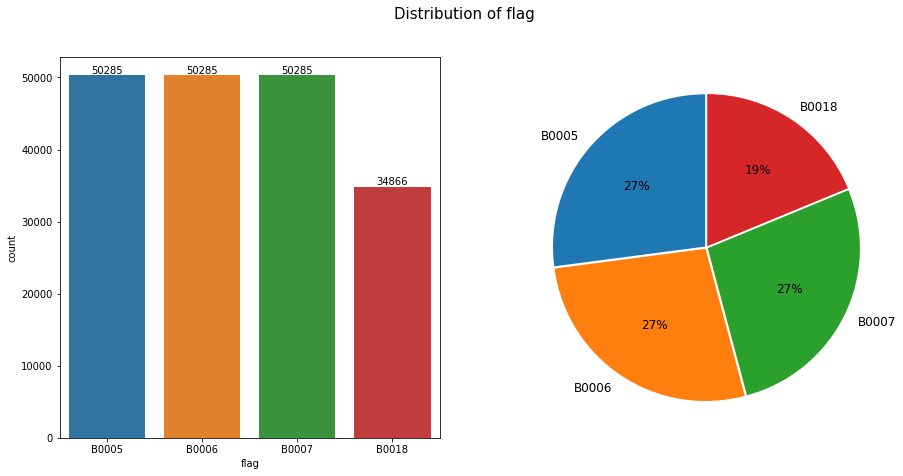

In [ ]:
make_categorical_plots(df, 'flag')

__Findings:__
- We have similar number of rows cell B0005, B0006, and B0007
- The number of rows for cell B0018 is slight less in comparison  to others

### Numerical Attributes

In [ ]:
def make_numerical_plots(df, feature, bins='auto', lim=(None, None)):
    """
    Method to make univariate numerical plot
    """
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15,7))
    f.suptitle(f'Distribution of {feature}', fontsize=15)

    # assigning a graph to each ax
    sns.boxplot(df[feature], ax=ax_box)
    sns.histplot(data=df, x=feature, ax=ax_hist, kde=True, bins=bins)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    ax_hist.set_ylim(*lim)

    plt.show()

def iqr(x):
    return x.quantile(q=0.75) - x.quantile(q=0.25)

def quantile_boundaries(x):
    upper_out = x.quantile(q=0.75) + 1.5 * iqr(x)
    lower_out = x.quantile(q=0.25) - 1.5 * iqr(x)
    return (lower_out, upper_out)

## Outlier > 75th %tile + 1.5IQR & < 25th %tile - 1.5IQR
def outlier_count(x):
    upper_out = x.quantile(q=0.75) + 1.5 * iqr(x)
    lower_out = x.quantile(q=0.25) - 1.5 * iqr(x)

    return len(x[x > upper_out]) + len(x[x < lower_out])

In [ ]:
df.select_dtypes('number').columns

Index(['cycle', 'ambient_temperature', 'capacity', 'voltage_measured',
       'current_measured', 'temperature_measured', 'current_load',
       'voltage_load', 'time'],
      dtype='object')

#### cycle

- Charge cycle of the fuel cell

In [ ]:
df['cycle'].describe()

count    185721.000000
mean         82.838758
std          45.692247
min           1.000000
25%          45.000000
50%          81.000000
75%         120.000000
max         168.000000
Name: cycle, dtype: float64

__Findings:__
- The count of charge cycle of the fuel cells ranges from 1 to 168
- The average count of charge cycle for the cells is 82. The median value is 81

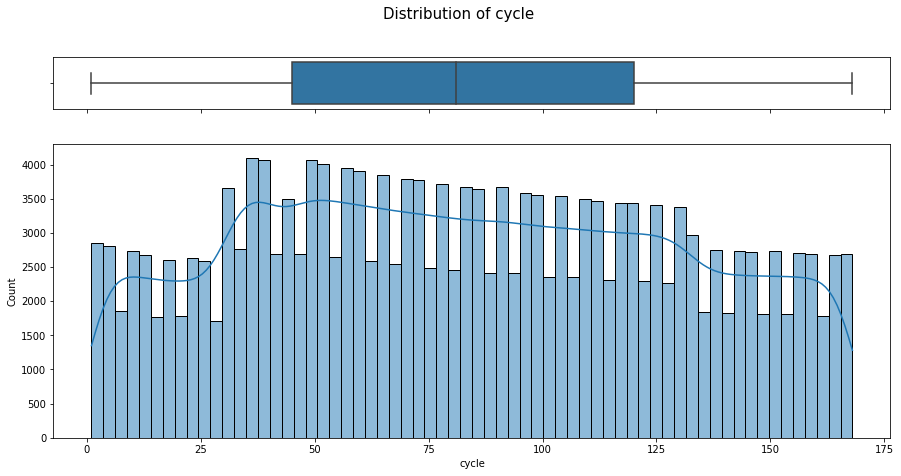

In [ ]:
make_numerical_plots(df, 'cycle')

__Findings:__
- The count of charge cycle of the fuel cells has almost an uniform distribution

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["cycle"])} are considered outliers')
print(f'There are {outlier_count(df["cycle"])} outlier data points')

The values lying ouside of (-67.5, 232.5) are considered outliers
There are 0 outlier data points


__Findings:__
- There is nothing unusual with the count of charge cycle cells.
- No data points were identified as outliers

#### capacity

- Fuel Cell capacity (Ahr) for discharge till 2.7V

In [ ]:
df['capacity'].describe()

count    185721.000000
mean          1.574863
std           0.190633
min           1.153818
25%           1.426025
50%           1.559634
75%           1.741850
max           2.035338
Name: capacity, dtype: float64

__Findings:__
- The capacity of the cells ranges from 1.1Ahr to 2Ahr
- The average capacity of the cells is 1.5Ahr. The median capcity is 1.5Ahr

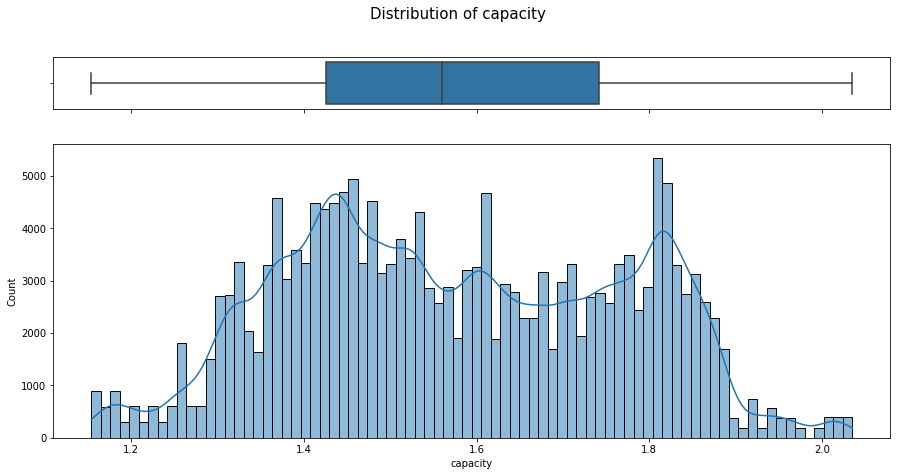

In [ ]:
make_numerical_plots(df, 'capacity')

__Findings:__
- There are multiple peaks in the data

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["capacity"])} are considered outliers')
print(f'There are {outlier_count(df["capacity"])} outlier data points')

The values lying ouside of (0.9522873876874277, 2.2155869350611446) are considered outliers
There are 0 outlier data points


__Findings:__
- No data point is identified as outliers

#### voltage_measured

- Fuel Cell terminal voltage (Volts)

In [ ]:
df['voltage_measured'].describe()

count    185721.000000
mean          3.497219
std           0.251691
min           1.737030
25%           3.377653
50%           3.500859
75%           3.655751
max           4.233325
Name: voltage_measured, dtype: float64

__Findings:__
- The terminal voltage (Volts) of the cells range from 1.7V to 4.2V
- The average terminal voltage of the cells is 2.3V. The median terminal voltage is is 3.5V

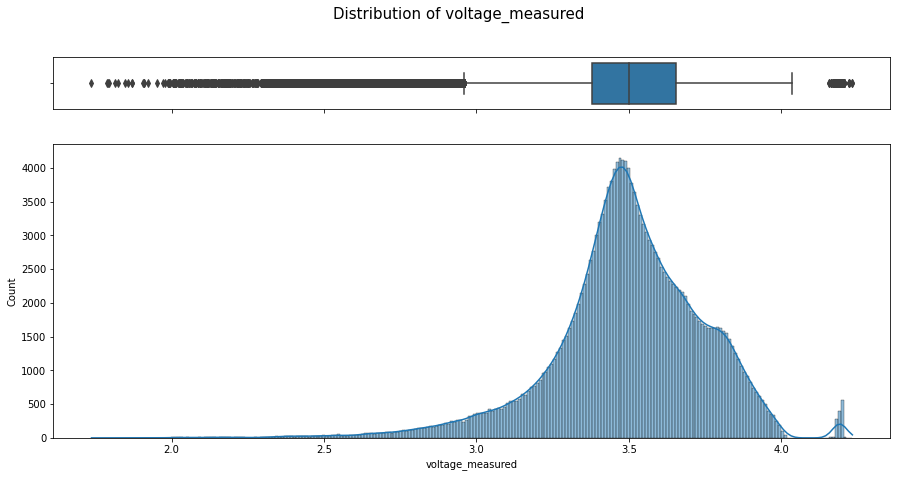

In [ ]:
make_numerical_plots(df, 'voltage_measured')

__Findings:__
- There seems to be a lot of outliers in the data

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["voltage_measured"])} are considered outliers')
print(f'There are {outlier_count(df["voltage_measured"])} outlier data points')

The values lying ouside of (2.960505971584876, 4.072898252810848) are considered outliers
There are 7267 outlier data points


In [ ]:
print(f"{round(7267  / df.shape[0] * 100, 2)}% of the data in voltage_measured are identified as outliers")

3.91% of the data in voltage_measured are identified as outliers


__Findings__
- Around 4% of the data are identified as outliers

#### current_measured

- Fuel Cell output current (Amps)

In [ ]:
df['current_measured'].describe()

count    185721.000000
mean         -1.832569
std           0.561405
min          -2.029098
25%          -2.011418
50%          -2.009015
75%          -1.989974
max           0.014306
Name: current_measured, dtype: float64

__Findings:__
- The output current (Amps) of the cells ranges from -2A to 0A
- The average output current (Amps) of the cells is -1.8A. The median value is -2A.

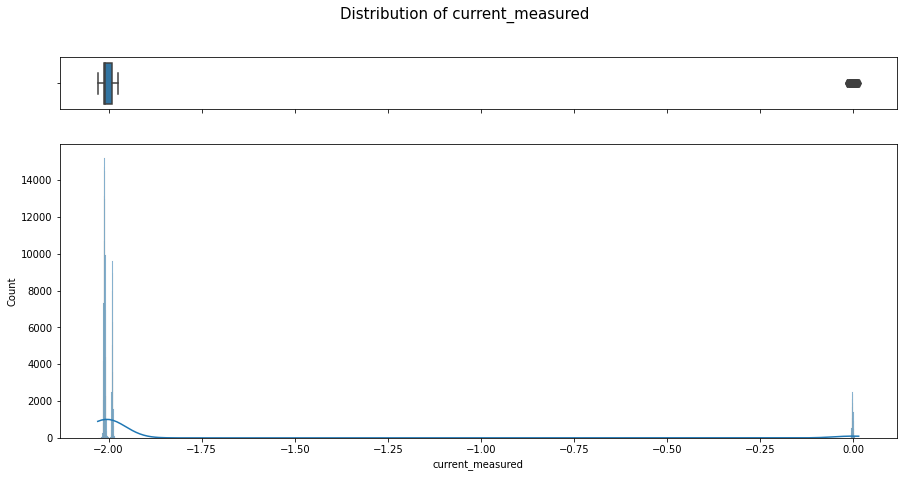

In [ ]:
make_numerical_plots(df, 'current_measured')

__Findings:__
- The distribution seems unusual. There seems to be multiple peaks

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["current_measured"])} are considered outliers')
print(f'There are {outlier_count(df["current_measured"])} outlier data points')

The values lying ouside of (-2.0435833073292673, -1.957808828831808) are considered outliers
There are 15955 outlier data points


In [ ]:
print(f"{round(15955  / df.shape[0] * 100, 2)}% of the data in current_measured are identified as outliers")

8.59% of the data in current_measured are identified as outliers


__Findings:__
- Around 8.6% of data is identified as outliers

#### temperature_measured

- Fuel Cell temperature (degree C)

In [ ]:
df['temperature_measured'].describe()

count    185721.000000
mean         32.378997
std           4.027737
min          22.350256
25%          29.570621
50%          32.355737
75%          35.420677
max          42.332522
Name: temperature_measured, dtype: float64

__Findings:__
- The temperature of the cells ranges from 22 to 42
- The average temperature of the cells is 32. The median temperature is also 32

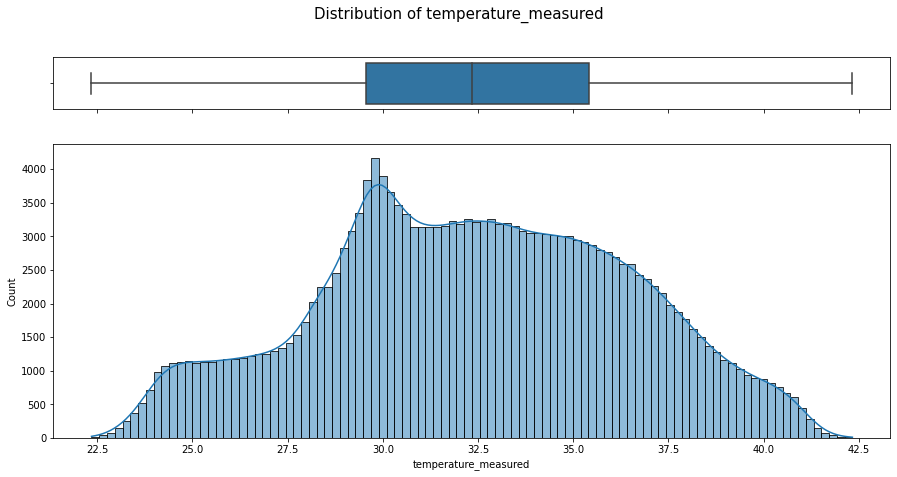

In [ ]:
make_numerical_plots(df, 'temperature_measured')

__Findings:__
- There is nothing unusual with the distribution of temperature_measured

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["temperature_measured"])} are considered outliers')
print(f'There are {outlier_count(df["temperature_measured"])} outlier data points')

The values lying ouside of (20.795537144048367, 44.19576164564245) are considered outliers
There are 0 outlier data points


__Findings:__
- No outliers were identified
- There is nothing that seems unusual with the temperature_measured

#### current_load

- Current measured at load (Amps)

In [ ]:
df['current_load'].describe()

count    185721.000000
mean          1.465434
std           1.226874
min          -2.000000
25%           1.998200
50%           1.998800
75%           1.999000
max           2.000000
Name: current_load, dtype: float64

__Findings:__
- The current measured at load can range from -2A to 2A
- On an average, current measured at load is 1.4A. The median value is 1.9A

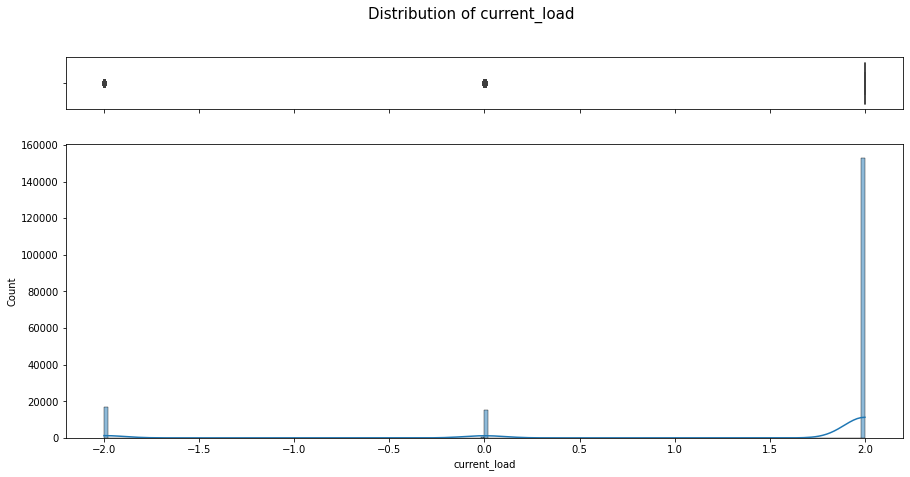

In [ ]:
make_numerical_plots(df, 'current_load', bins=200)

__Findings:__
- There are multiple peaks in the distribution.

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["current_load"])} are considered outliers')
print(f'There are {outlier_count(df["current_load"])} outlier data points')

The values lying ouside of (1.9969999999999999, 2.0002000000000004) are considered outliers
There are 32765 outlier data points


In [ ]:
print(f"{round(32765 / df.shape[0] * 100, 2)}% of the data in current_load are identified as outliers")

17.64% of the data in current_load are identified as outliers


__Findings:__
- Around 17.64% of the data are identified as outliers.

#### voltage_load

- Voltage measured at load (Volts)

In [ ]:
df['voltage_load'].describe()

count    185721.000000
mean          2.366494
std           0.751377
min           0.000000
25%           2.410000
50%           2.558000
75%           2.718000
max           4.249000
Name: voltage_load, dtype: float64

__Findings:__
- The voltage measured at load can range from 0 to 4.24
- The average voltage load is 2.36V. The median value is 2.55V.

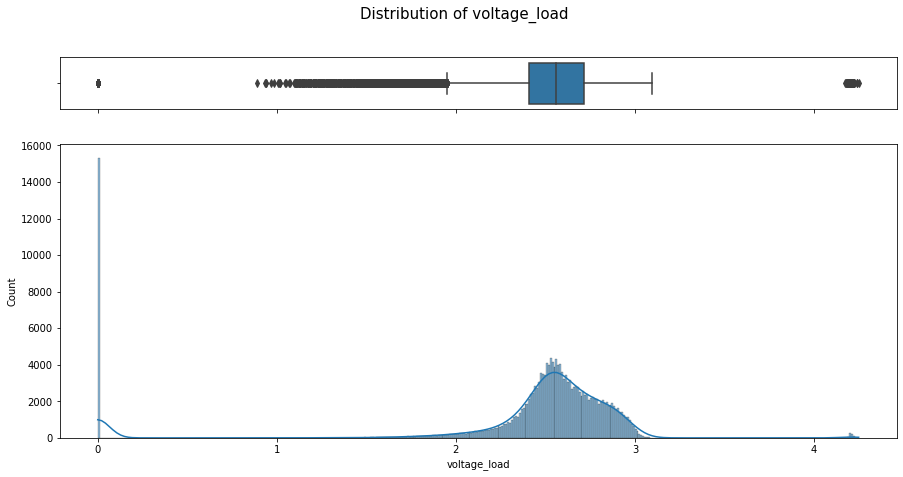

In [ ]:
make_numerical_plots(df, 'voltage_load')

__Findings:__
- We see some unusual spikes in voltage_load
- They are most likely to be noise, but we will dig them deeper in the further analysis

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["voltage_load"])} are considered outliers')
print(f'There are {outlier_count(df["voltage_load"])} outlier data points')

The values lying ouside of (1.9480000000000004, 3.1799999999999997) are considered outliers
There are 19459 outlier data points


In [ ]:
print(f"{round(21259 / df.shape[0] * 100, 2)}% of the data in voltage_load are identified as outliers")

11.45% of the data in voltage_load are identified as outliers


__Findings:__
- Around 11.45% of the data are identified as outliers.

#### time

- Time vector for the cycle

In [ ]:
df['time'].describe()

count    185721.000000
mean       1546.379935
std         906.958628
min           0.000000
25%         764.797000
50%        1537.031000
75%        2307.485000
max        3690.234000
Name: time, dtype: float64

__Findings:__
- The time vector for the charge cycles ranges from 0 to 3690s
- The average time is 1546s. Median time is 1537s

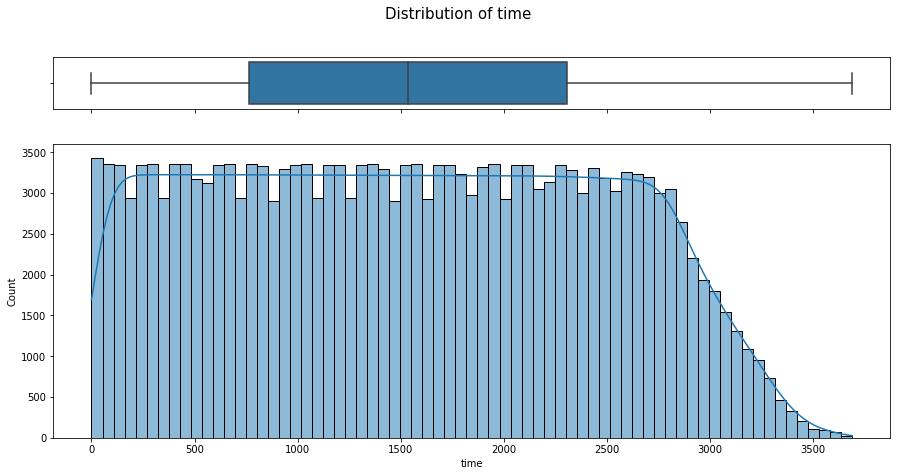

In [ ]:
make_numerical_plots(df, 'time')

__Findings:__
- The time vector for charge cycles has a uniform distribution

In [ ]:
print(f'The values lying ouside of {quantile_boundaries(df["time"])} are considered outliers')
print(f'There are {outlier_count(df["time"])} outlier data points')

The values lying ouside of (-1549.2350000000001, 4621.517) are considered outliers
There are 0 outlier data points


__Findings:__
- There is nothing unusual with the charging cycle times

### Datetime Attributes

#### datetime

In [ ]:
df['datetime'].describe()

count                  185721
unique                    300
top       2008-04-22 15:33:49
freq                     1113
first     2008-04-02 15:25:41
last      2008-08-20 08:37:19
Name: datetime, dtype: object

In [ ]:
df['datetime'].dt.to_period('D').nunique()

74

__Findings__
- We have data from 2008 April to 2008 Aug
- The data is available for 74 unique days

__Count of rows (month wise)__

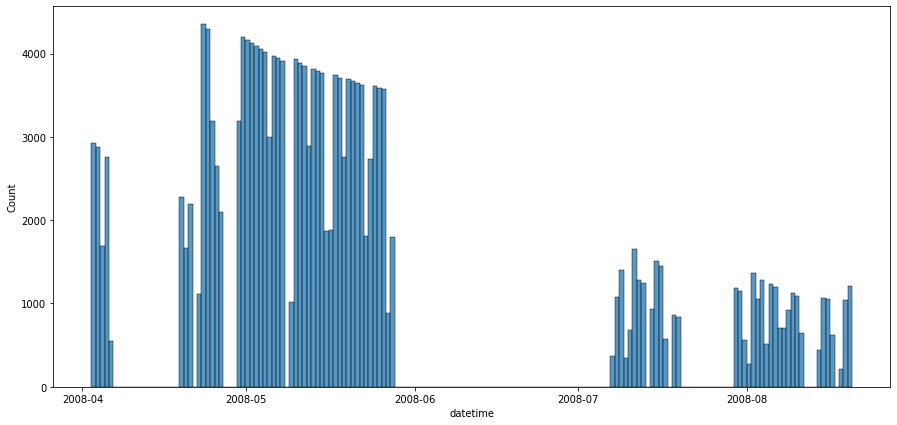

In [ ]:
plt.figure(figsize=(15,7))
sns.histplot(df['datetime'])
plt.show()

__Findings__
- The sensor informations are available for the months April, May, July, and August
- There is no data for June

## Summary

We applied traditional methods like IQR, Boxplot, etc to check for anomalies in the data. The details of outliers that were identified are summarized below:

|sl no| feature | %age of outliers|
|---|---|---|
|1| cycle| No outliers|
|2| capacity | No outliers|
|3| voltage_measured| 3.91|
|4| current_measured| 8.59|
|5| temperature_measured| No outliers|
|6| current_load| 17.64|
|7| voltage_load| 11.45|
|8| time| No outliers|

## Bivariate Analysis



In [ ]:
df_copy = df.copy()

In [ ]:
df_copy.reset_index(drop=True, inplace=True)
df_copy.drop(columns=['ambient_temperature'], inplace=True)

### Pairplot, Correlation

In [ ]:
df_copy['datetime'] = df_copy['datetime'].astype('int')

<Figure size 1080x504 with 0 Axes>

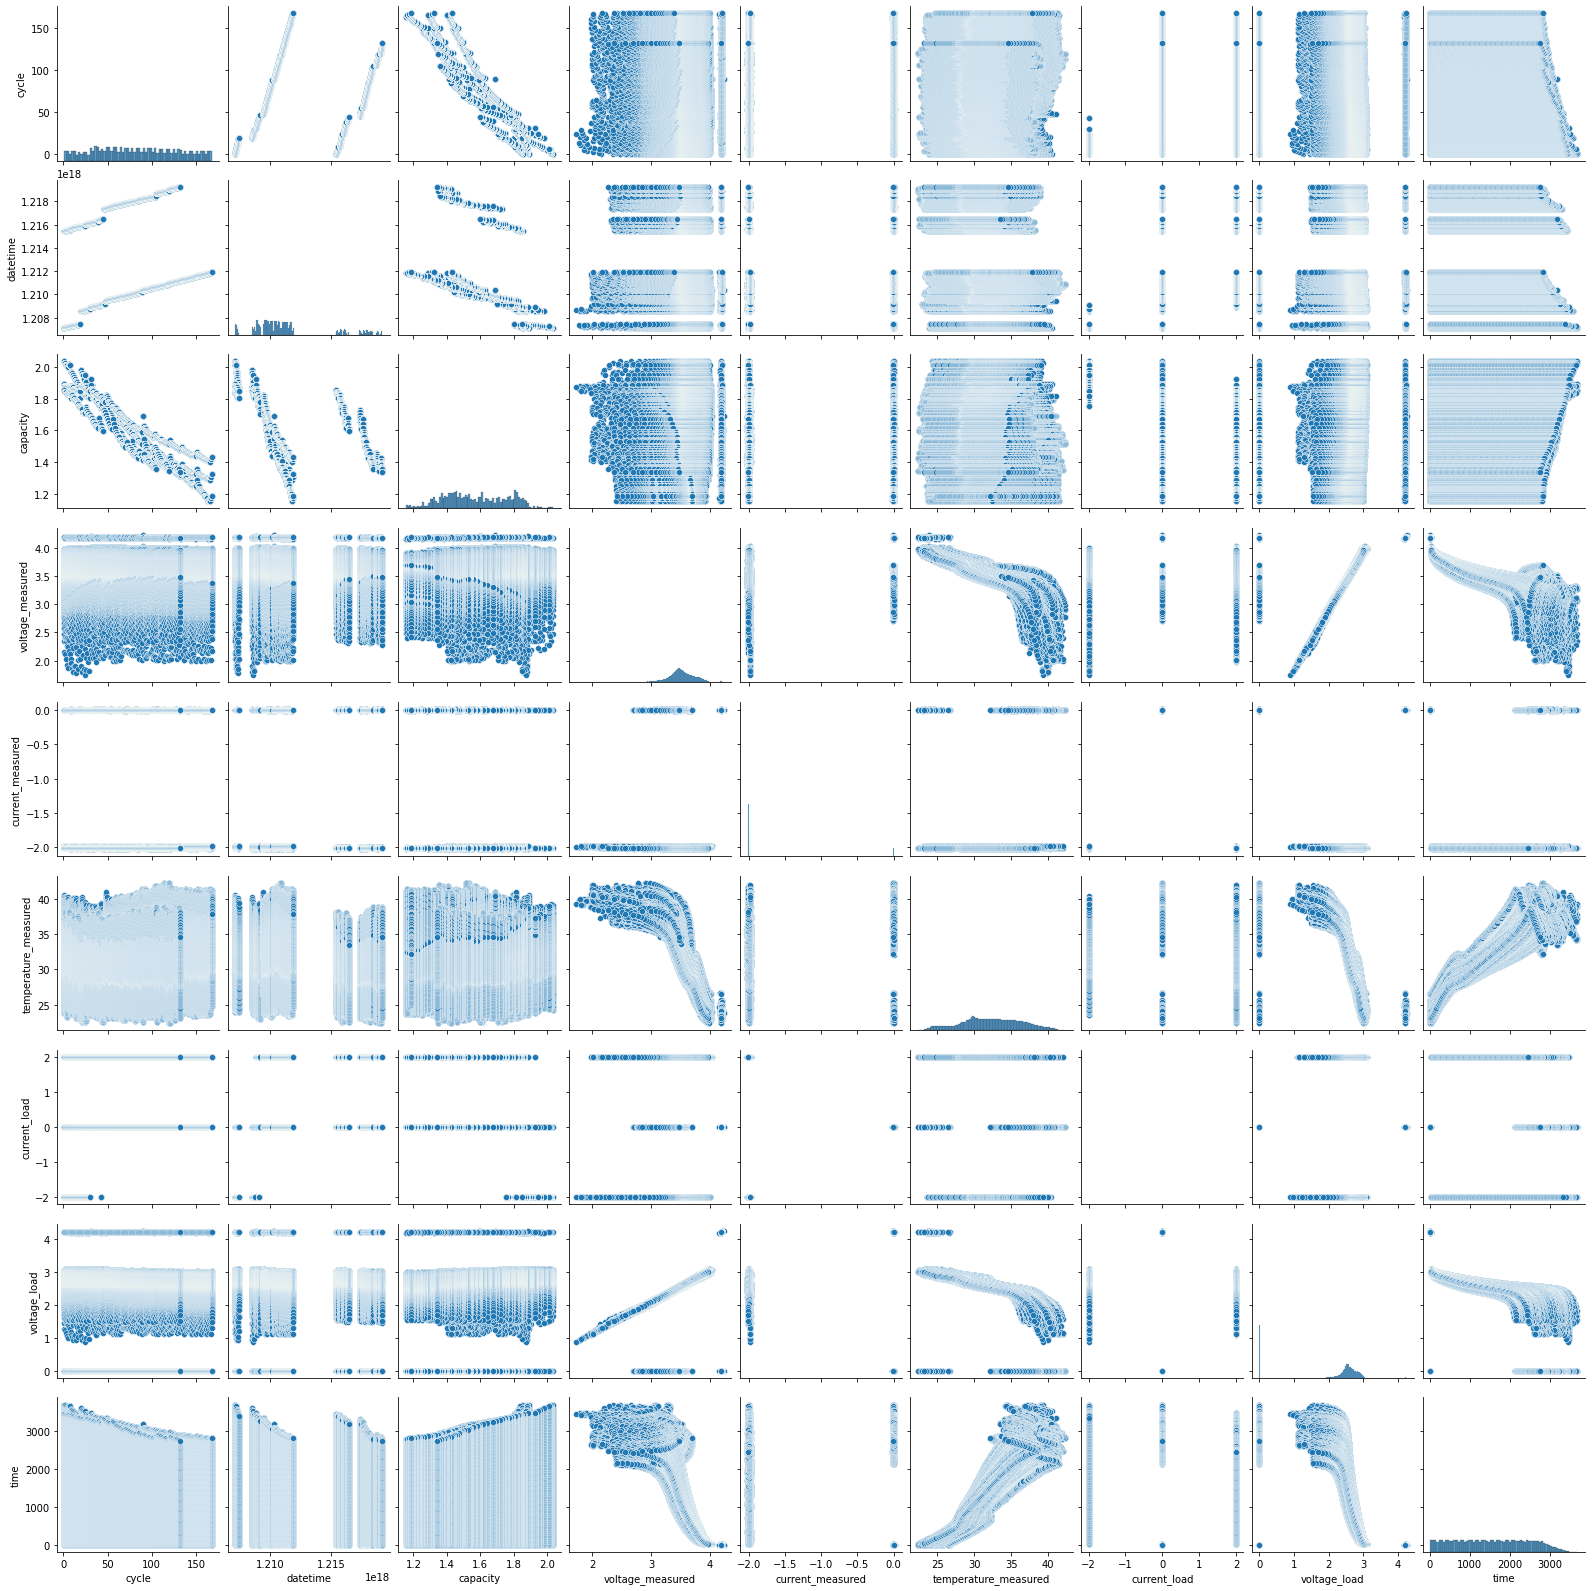

In [ ]:
plt.figure(figsize=(15,7))
sns.pairplot(df_copy)
plt.show()

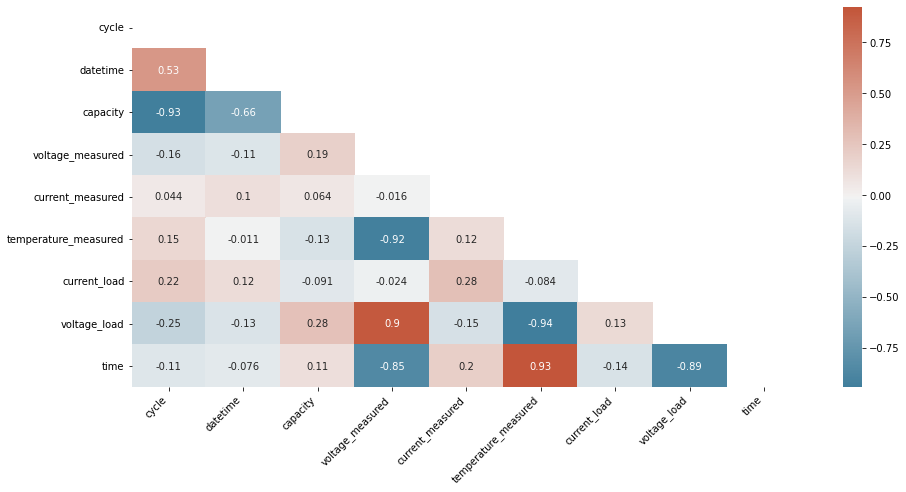

In [ ]:
# Correlation between different variables
corr = df_copy.corr(method='spearman')

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(15, 7))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

__Findings:__

__1 There are strong positive correlation between some of the feature pairs__
- "datetime" and "cycle" (0.53)
- "voltage_load" and "voltage_measured" (0.9)
- "time" and "temperature_measured" (0.93)

__2 There are strong negative correlation between some of the feature pairs__
- "capacity" and "cycle" (-0.93)
- "capacity" and "datetime" (-0.66)
- "temperature_measured" and "voltage_measured" (-0.92)
- "time" and "voltage_measured" (-0.85)
- "voltage_load" and "temperature_measured" (-0.94)
- "time" and "voltage_load" (-0.89)

__3 The correlation between rest of the feature pairs are weak__

We will dig in deeper to understand the high correlation pairs better.

In [ ]:
def plot_bivariate(df, x, y):
    plt.figure(figsize=(15, 7))
    sns.lineplot(x=x, y=y, data=df, hue='flag')
    plt.grid()
    plt.title(f'Plot for {x} vs {y}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

### datetime vs capacity

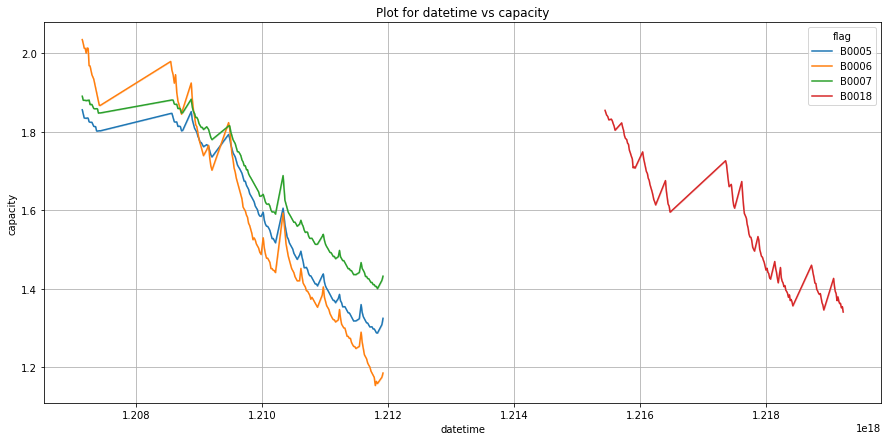

In [ ]:
plot_bivariate(df_copy, 'datetime', 'capacity')

__Findings__
- As the number of charge cycle for a cell increases, the capacity of the cell also tends to decrease
- The degradation in capacity of cell B0005 and B0007 are almost similar. However, the degradation of cell B0006 is extreme
- The cell B0018 is more recent than the other cells, and it degradation rate is lowest among all. 

### time vs temperature_measured

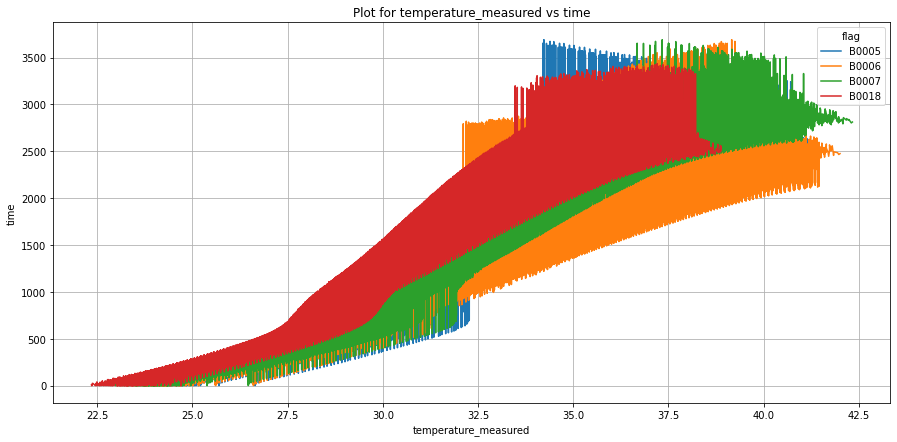

In [ ]:
plot_bivariate(df_copy, 'temperature_measured', 'time')

__Findings__
- The temperature of the cell increases when they are charged for a longer duration
- The rate of increase in temperature of cell B0018 is lowest among the four. Also, cell B0018 stays comparatively cooler for a longer duration than the others.

### time vs voltage_measured

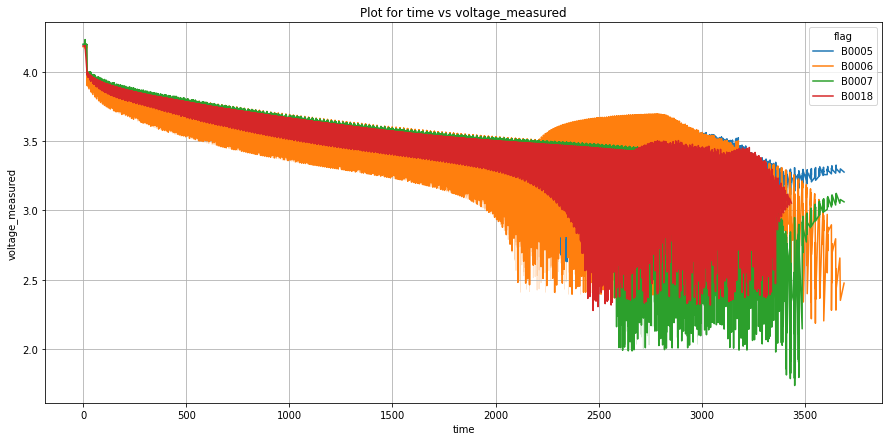

In [ ]:
plot_bivariate(df_copy, 'time', 'voltage_measured')

__Findings__
- As the time increases, the terminal voltage decreases
- The voltage drop is highest for B0007 cell.
- The voltage drop is most stable in cell B0018. The voltage drop is comparatively lesser, and also slower

### time vs voltage_load

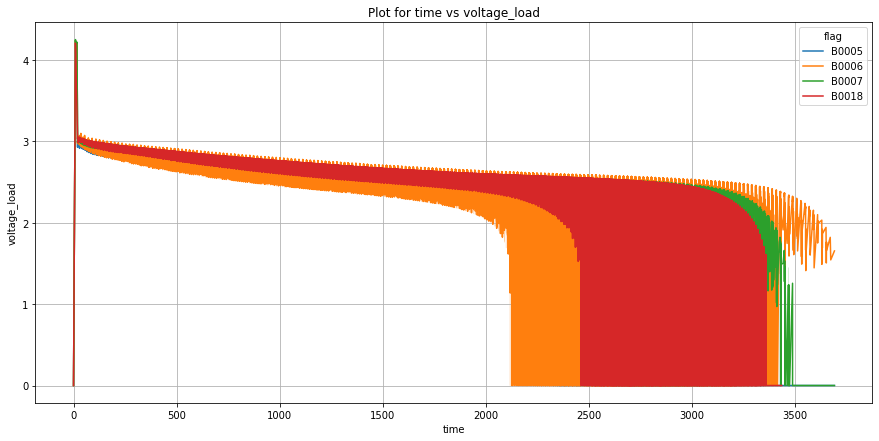

In [ ]:
plot_bivariate(df_copy, 'time', 'voltage_load')

__Findings__
- Cell B006 lasts longer as compared to others
- All the cells provide a stable voltage throughout before draining out.

### capacity vs cycle

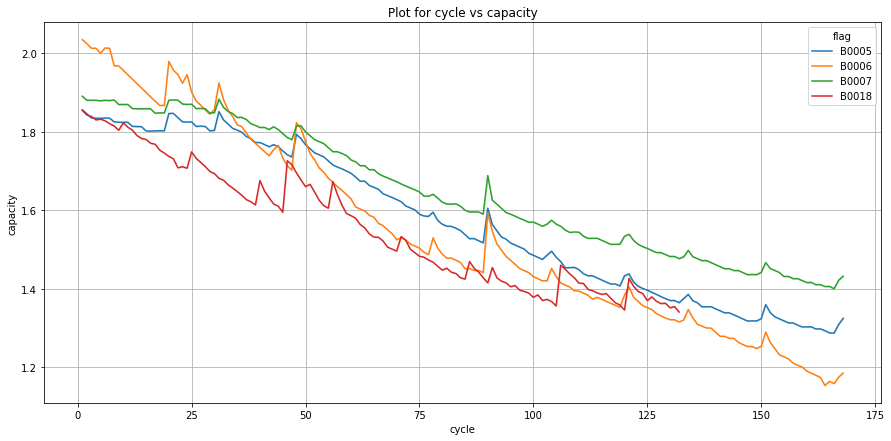

In [ ]:
plot_bivariate(df_copy, 'cycle', 'capacity')

__Findings__
- The capacity of the cells decreases as the number of cycles it is used increases
- The degradation rate is highest for cell B0006, and lowest for B0018

### temperature_measured vs voltage_measured

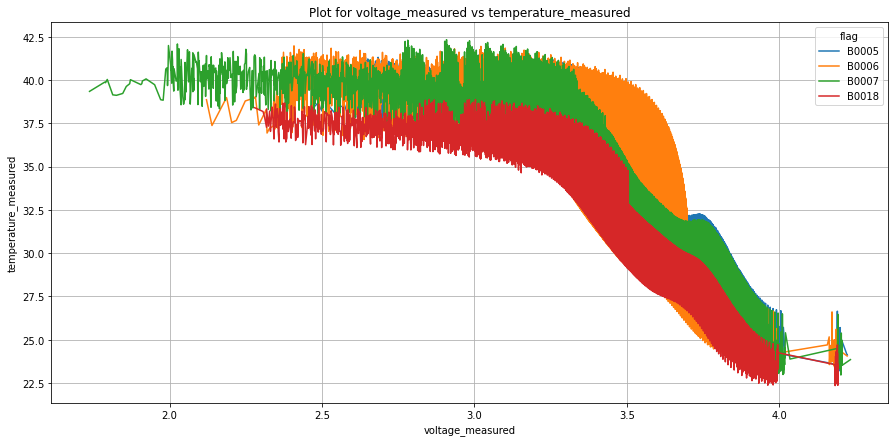

In [ ]:
plot_bivariate(df_copy, 'voltage_measured', 'temperature_measured')

__Findings__
- The temperature of the cells decreases as the terminal voltage in the cell increases

### temperature_measured vs voltage_load

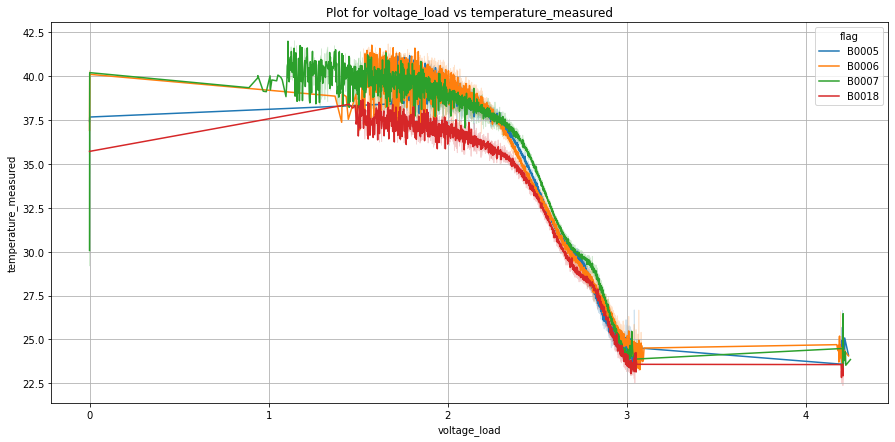

In [ ]:
plot_bivariate(df_copy, 'voltage_load', 'temperature_measured')

__Findings__
- The temperature of the cells decreases as the voltage load increases

# Data Preparation + Model Based Anamoly Detection

We tried the traditional way of finding outliers using IQR, and Boxplot. This analysis, however, is not comprehensive because there are interactions among many of these features.

Hence we will now use Model based techniques to find anomalies in the data.



Before that, we will normalize the features in the data, so they can be used in the model:

__ENCODE__

In [ ]:
flag_dict = {
    'B0005': 1,
    'B0006': 2,
    'B0007': 3,
    'B0018': 4
}

df_copy['flag'] = df_copy['flag'].map(flag_dict)

__NORMALIZE__

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
num_cols = ['cycle', 'datetime', 'capacity',        \
            'voltage_measured', 'current_measured', \
            'temperature_measured', 'current_load', \
            'voltage_load', 'time']

In [ ]:
for col in num_cols:
    sc = MinMaxScaler().fit(df_copy[col].values.reshape(-1, 1))
    df_copy[col] = sc.transform(df_copy[col].values.reshape(-1, 1))

In [ ]:
cols = ['flag'] + num_cols
print(cols)

['flag', 'cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured', 'temperature_measured', 'current_load', 'voltage_load', 'time']


### Isolation forest


In [ ]:
df_if = df_copy.copy()

In [ ]:
from sklearn.ensemble import IsolationForest

contamination = [0.01, 0.02, 0.03, 0.04]

for c in contamination:
    model = IsolationForest(n_estimators=200, 
                            contamination=c, 
                            random_state=42
                            )
    df_if['pred' + str(c)] = model.fit_predict(df_if[cols])
    df_if['scores' + str(c)] = model.decision_function(df_if[cols])

#### Result Analysis

In [ ]:
contamination = [0.01, 0.02, 0.03, 0.04]

for c in contamination:
    print(f"anomalies with contamination {c} --> {len(df_if[df_if['pred'+str(c)]==-1])}")

Anamolies with contamination 0.01 --> 1857
Anamolies with contamination 0.02 --> 3715
Anamolies with contamination 0.03 --> 5572
Anamolies with contamination 0.04 --> 7429


__Deep diving the anomalies__

- For below analysis, we will look at the anomalies for contamination = 0.01

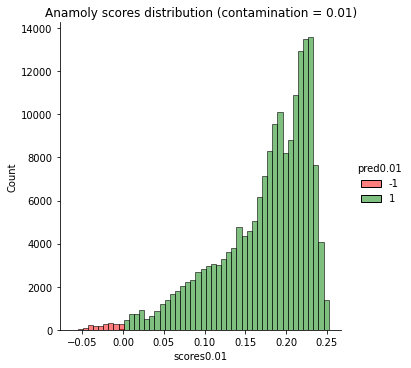

In [ ]:
sns.displot(x='scores0.01', hue='pred0.01', palette=['r', 'g'], data=df_if, bins=50)
plt.title('Anamoly scores distribution (contamination = 0.01)')
plt.show()

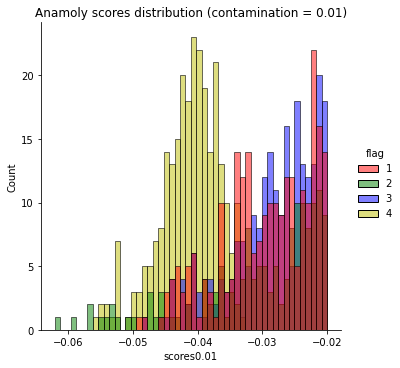

In [ ]:
sns.displot(x='scores0.01', 
            hue='flag', 
            palette=['r', 'g', 'b', 'y'], 
            data=df_if[df_if['scores0.01'] < -0.02], 
            bins=50
            )
plt.title('Anamoly scores distribution (contamination = 0.01)')
plt.show()

In [ ]:
df_if[['flag', 'pred0.01', 'scores0.01']].groupby(['flag', 'pred0.01']).agg('count')

scores0.01
flag pred0.01            
1    -1               545
      1             49740
2    -1               366
      1             49919
3    -1               492
      1             49793
4    -1               454
      1             34412

__Findings__
- The extreme anomalies come from battery cell 2 (B0006)
- Most of the anomalies are detected in cell 1 (B0005)

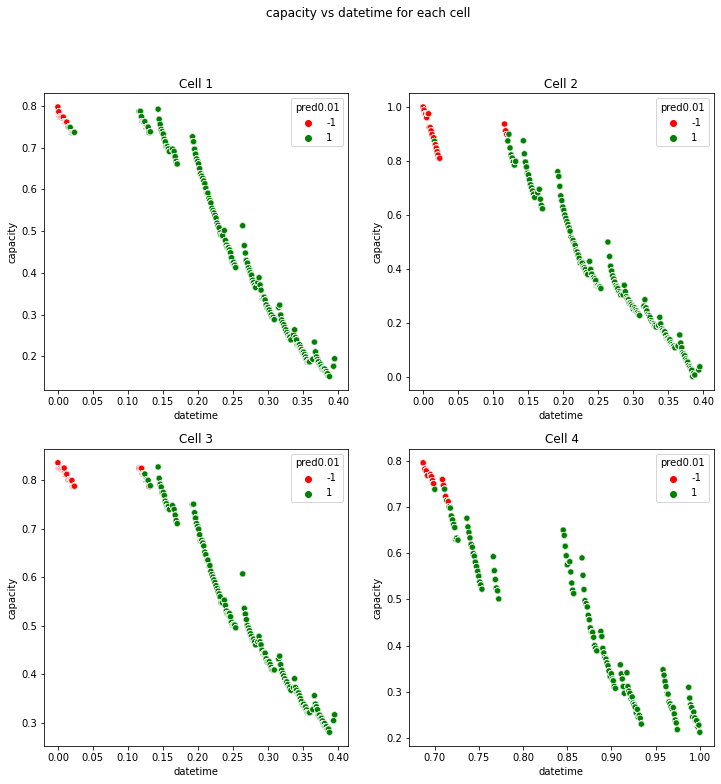

In [ ]:
col = 'capacity'

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()

fig.suptitle(f'{col} vs datetime for each cell')

for i in range(1, 5):
    data = df_if[df_if['flag']==i]
    ax[i-1].set_title(f'Cell {i}')
    sns.scatterplot('datetime', col, data=data, hue='pred0.01', ax=ax[i-1], palette=['r', 'g'])

plt.show()

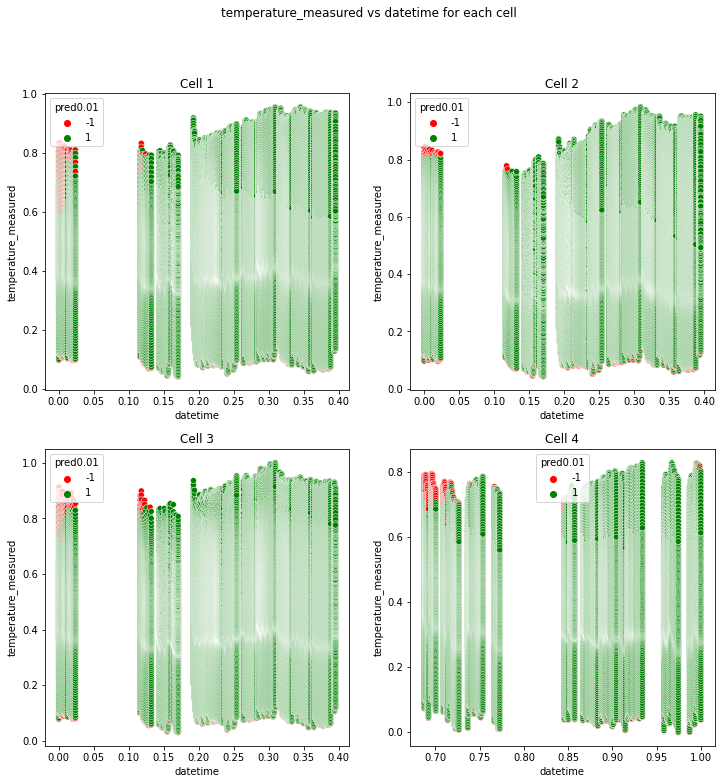

In [ ]:
col = 'temperature_measured'

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()

fig.suptitle(f'{col} vs datetime for each cell')

for i in range(1, 5):
    data = df_if[df_if['flag']==i]
    ax[i-1].set_title(f'Cell {i}')
    sns.scatterplot('datetime', col, data=data, hue='pred0.01', ax=ax[i-1], palette=['r', 'g'])

plt.show()

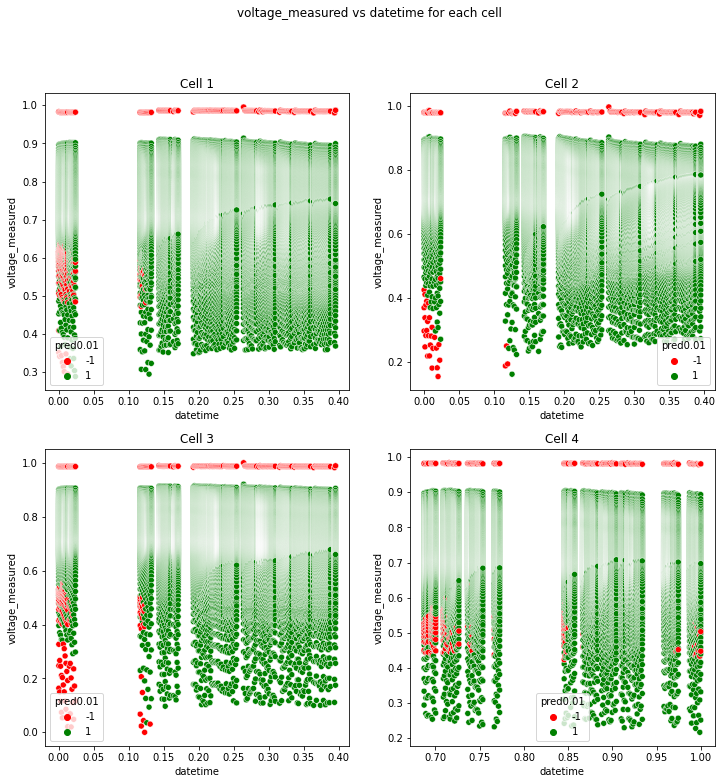

In [ ]:
col = 'voltage_measured'

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()

fig.suptitle(f'{col} vs datetime for each cell')

for i in range(1, 5):
    data = df_if[df_if['flag']==i]
    ax[i-1].set_title(f'Cell {i}')
    sns.scatterplot('datetime', col, data=data, hue='pred0.01', ax=ax[i-1], palette=['r', 'g'])

plt.show()

__Findings__
- The terminal voltage is unusually high for anomalies
- The cell temperature is also high in the beginning

### Local Outlier Factor


In [ ]:
from sklearn.neighbors import LocalOutlierFactor
df_lof = df_copy.copy()

In [ ]:
contamination = [0.01, 0.02, 0.03, 0.04]

for c in contamination:
    model = LocalOutlierFactor(n_neighbors=20, contamination=c)
    df_lof['pred' + str(c)] = model.fit_predict(df_lof)
    df_lof['scores' + str(c)] = model.negative_outlier_factor_

#### Result Analysis

In [ ]:
contamination = [0.01, 0.02, 0.03, 0.04]

for c in contamination:
    print(f"anomalies with contamination {c} --> {len(df_lof[df_lof['pred'+str(c)]==-1])}")

Anamolies with contamination 0.01 --> 1858
Anamolies with contamination 0.02 --> 3715
Anamolies with contamination 0.03 --> 5572
Anamolies with contamination 0.04 --> 7429


__Deep diving the anomalies__

- For below analysis, we will look at the anomalies for contamination = 0.01

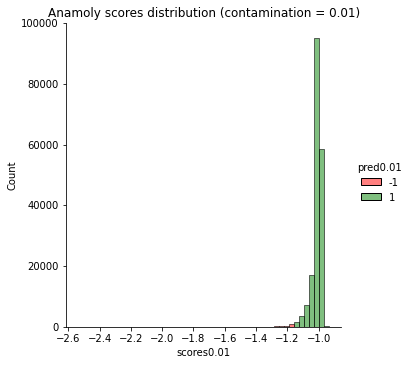

In [ ]:
sns.displot(x='scores0.01', hue='pred0.01', palette=['r', 'g'], data=df_lof, bins=50)
plt.title('Anamoly scores distribution (contamination = 0.01)')
plt.show()

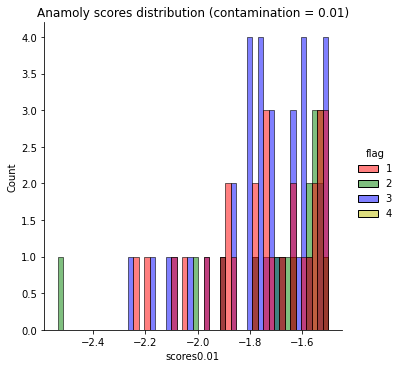

In [ ]:
sns.displot(x='scores0.01', 
            hue='flag', 
            palette=['r', 'g', 'b', 'y'], 
            data=df_lof[df_lof['scores0.01'] < -1.5], 
            bins=50
            )
plt.title('Anamoly scores distribution (contamination = 0.01)')
plt.show()

In [ ]:
df_lof[['flag', 'pred0.01', 'scores0.01']].groupby(['flag', 'pred0.01']).agg('count')

scores0.01
flag pred0.01            
1    -1               634
      1             49651
2    -1               568
      1             49717
3    -1               391
      1             49894
4    -1               265
      1             34601

__Findings__
- The extreme anomalies come from battery cell 2 (B0006)
- Most of the anomalies are detected in cell 1 (B0005)

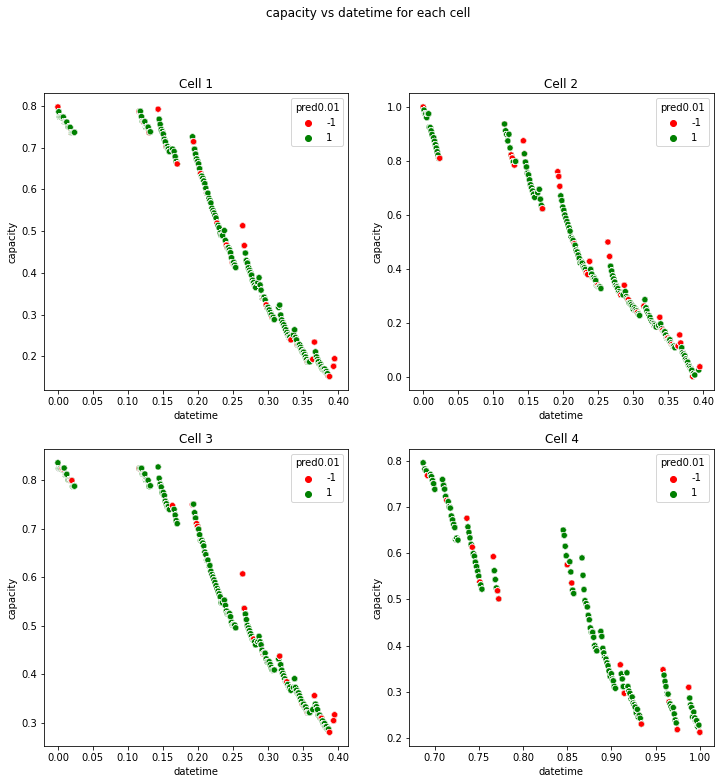

In [ ]:
col = 'capacity'

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()

fig.suptitle(f'{col} vs datetime for each cell')

for i in range(1, 5):
    data = df_lof[df_lof['flag']==i]
    ax[i-1].set_title(f'Cell {i}')
    sns.scatterplot('datetime', col, data=data, hue='pred0.01', ax=ax[i-1], palette=['r', 'g'])

plt.show()

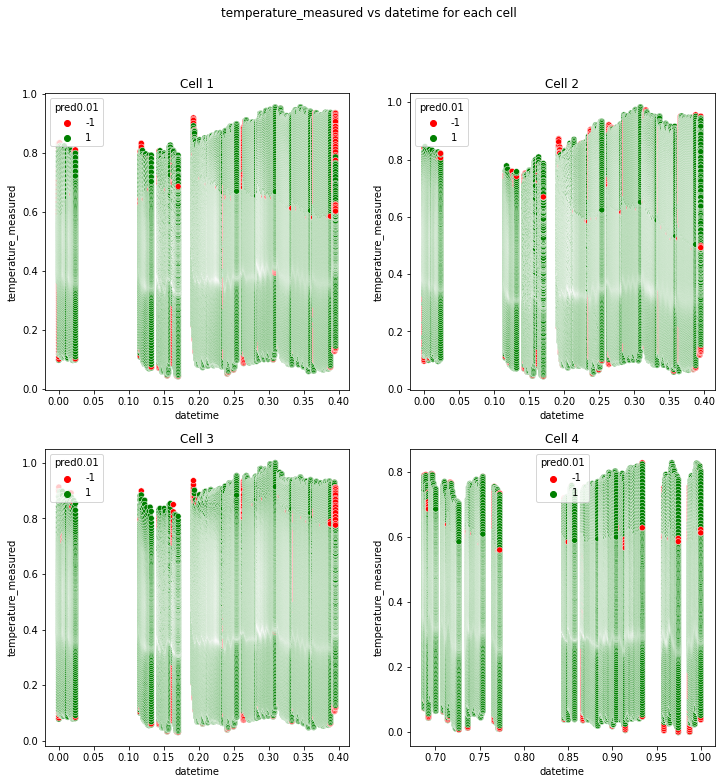

In [ ]:
col = 'temperature_measured'

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()

fig.suptitle(f'{col} vs datetime for each cell')

for i in range(1, 5):
    data = df_lof[df_lof['flag']==i]
    ax[i-1].set_title(f'Cell {i}')
    sns.scatterplot('datetime', col, data=data, hue='pred0.01', ax=ax[i-1], palette=['r', 'g'])

plt.show()

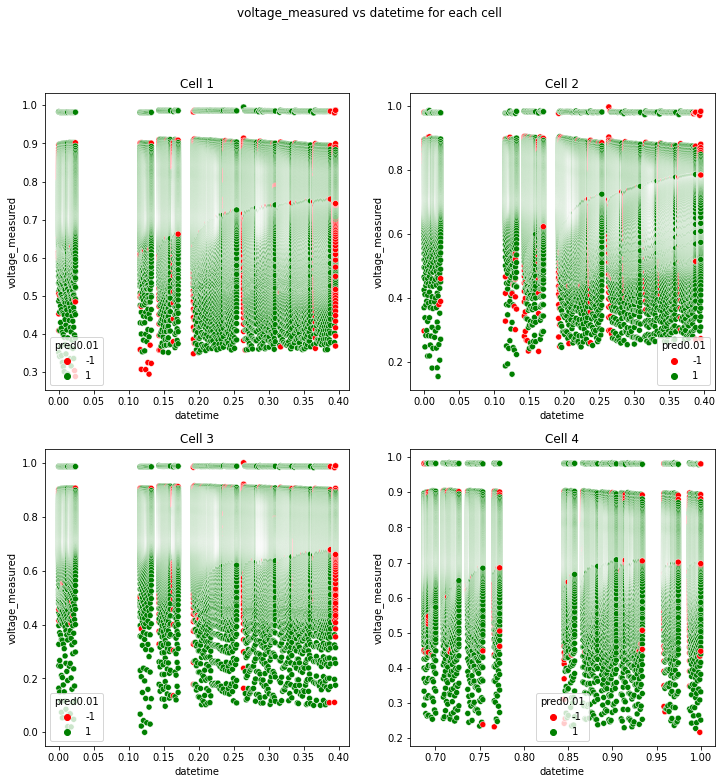

In [ ]:
col = 'voltage_measured'

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()

fig.suptitle(f'{col} vs datetime for each cell')

for i in range(1, 5):
    data = df_lof[df_lof['flag']==i]
    ax[i-1].set_title(f'Cell {i}')
    sns.scatterplot('datetime', col, data=data, hue='pred0.01', ax=ax[i-1], palette=['r', 'g'])

plt.show()

__Findings__
- The signals are not quite distinguishable among inliers and outliers

### Optional: Elliptical Envelope

In [ ]:
from sklearn.covariance import EllipticEnvelope
df_ee = df_copy.copy()

In [ ]:
contamination = [0.01, 0.02, 0.03, 0.04]

for c in contamination:
    model = EllipticEnvelope(contamination=c, random_state=42)
    df_ee['pred' + str(c)] = model.fit_predict(df_ee)

#### Result Analysis

In [ ]:
contamination = [0.01, 0.02, 0.03, 0.04]

for c in contamination:
    print(f"anomalies with contamination {c} --> {len(df_ee[df_ee['pred'+str(c)]==-1])}")

Anamolies with contamination 0.01 --> 1858
Anamolies with contamination 0.02 --> 3715
Anamolies with contamination 0.03 --> 5572
Anamolies with contamination 0.04 --> 7429


__Deep diving the anomalies__

- For below analysis, we will look at the anomalies for contamination = 0.01

In [ ]:
df_ee[['flag', 'pred0.01', 'cycle']].groupby(['flag', 'pred0.01']).agg('count')

cycle
flag pred0.01       
1     1        50285
2     1        50285
3    -1         1858
      1        48427
4     1        34866

In [ ]:
df_ee[['flag', 'pred0.02', 'cycle']].groupby(['flag', 'pred0.02']).agg('count')

cycle
flag pred0.02       
1     1        50285
2     1        50285
3    -1         3715
      1        46570
4     1        34866

In [ ]:
df_ee[['flag', 'pred0.03', 'cycle']].groupby(['flag', 'pred0.03']).agg('count')

cycle
flag pred0.03       
1     1        50285
2     1        50285
3    -1         5572
      1        44713
4     1        34866

In [ ]:
df_ee[['flag', 'pred0.04', 'cycle']].groupby(['flag', 'pred0.04']).agg('count')

cycle
flag pred0.04       
1     1        50285
2    -1         1780
      1        48505
3    -1         5649
      1        44636
4     1        34866

__Findings__
- Almost all of the anomalies are detected in cell 3 (B0007) only
- Few anomalies are detected in cell 2 (B0006) only upon increasing the contamination percentage

### Comparision of results

- The results are based on contamination = 0.01

In [ ]:
num_cols = ['cycle', 'datetime', 'capacity',        \
            'voltage_measured', 'current_measured', \
            'temperature_measured', 'current_load', \
            'voltage_load', 'time'] 

cols = num_cols + ['flag']

In [ ]:
from umap import UMAP

umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(df_copy.loc[:, cols])

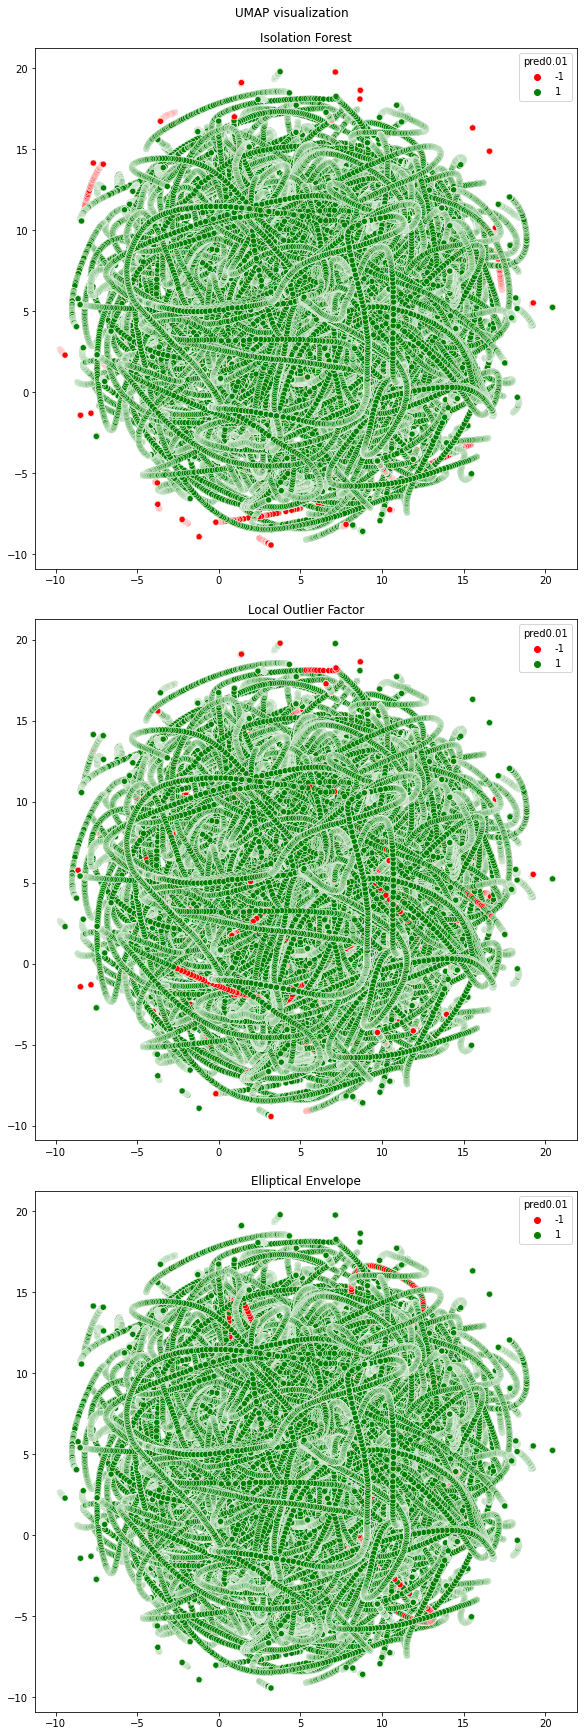

In [ ]:

fig, ax = plt.subplots(3, 1, figsize=(8, 24), constrained_layout=True)
ax = ax.flatten()

fig.suptitle(f'UMAP visualization')

ax[0].set_title(f'Isolation Forest')
sns.scatterplot(proj_2d[:, 0], proj_2d[:, 1], ax=ax[0],
                palette=['r', 'g'], hue=df_if['pred0.01']
                )

ax[1].set_title(f'Local Outlier Factor')
sns.scatterplot(proj_2d[:, 0], proj_2d[:, 1], ax=ax[1],
                palette=['r', 'g'], hue=df_lof['pred0.01']
                )

ax[2].set_title(f'Elliptical Envelope')
sns.scatterplot(proj_2d[:, 0], proj_2d[:, 1], ax=ax[2],
                palette=['r', 'g'], hue=df_ee['pred0.01']
                )
plt.show()

__Findings__
- The anomaly points seems to be identified better in Isolation forest, as compared to others.

## Summary

- The pattern in Isolation Forest results were more distinguishable than Local Outlier Factor
- Both the method identified the extreme anomalies to come from battery cell 2 (B0006), and the highest count of anomalies from cell 1 (B0005)

# Recommendations:



In [3]:
observations = [
    """The degradation rate of cell B0018 in terms of capacity, and terminal
    voltage drop is slowest among all. Also, the temperature of this cell
    stays cooler for longer duration as compared to others.""",

    """High terminal voltage, and high temperature cell are the most
    determining factors for anomalies.""",
    
    """The capacity of the cells decreases as the number of charge cycles
    increases.""" ,
    ]


recommendations = [
    """The company should put more focus, and try to tackle the pitfalls in
    cell B0018 to further improve its performance and efficiency.
    """ ,

    """The company should put more emphasize on controlling the terminal
    voltage and temperature of their FCEV cells for better results. 
    The terminal voltage is high, when the temperature of the cell remains low.""",

    """The company should focus on reducing the discharge rate of the cells.
    This could come as introduction of design changes in the vehicle to make it 
    more aerodynamic. Increased efficiency will require less power, leading to
    slower discharge of the cell. And as such, the charging requirement of the
    cell will also decrease, resulting in an increased lifetime of the cell.""",

    ]

x = PrettyTable(["Sl no", "Observations", "Recommendations"]) 
i = 1
for a, b in zip(observations, recommendations):
    x.add_row([i, a, b])
    x.add_row([' ', ' ', ' '])
    i += 1
print(x)

+-------+---------------------------------------------------------------------------+----------------------------------------------------------------------------------+
| Sl no |                                Observations                               |                                 Recommendations                                  |
+-------+---------------------------------------------------------------------------+----------------------------------------------------------------------------------+
|   1   |   The degradation rate of cell B0018 in terms of capacity, and terminal   |       The company should put more focus, and try to tackle the pitfalls in       |
|       |     voltage drop is slowest among all. Also, the temperature of this cell |            cell B0018 to further improve its performance and efficiency.         |
|       |            stays cooler for longer duration as compared to others.        |                                                                      